# Homework - Reinforcement Learning - Part B (60/100 points)

by *Todd Gureckis* and *Brenden Lake*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

<div class="alert alert-danger" role="alert">
  This homework is due before midnight on March 21, 2022.  
</div>

---

## Learning and deciding in an unknown world

[Part A](Homework-RL-A.ipynb) of the homework explored various solution to a sequential decision making problem in a case where considerable information about the environment was known or was provided (e.g., the probabilities of transitioning between different states and the magnitude of rewards available in particular states).  However, if reinforcement learning could only be applied to cases with full, explicit knowledge than it would be much less of a compelling model of human learning.  In many cases, humans and other animals learn even when there is much more ambiguity, and as a result, a good model of experiential learning for humans would apply to cases where less is known a-priori about the world.

<img src="images/bandit.jpg" width="200">

In this part of the homework, we will shift to think about learning and deciding in a unknown environment.  This is a fairly complex topic with many different solutions and types of problems.  However, we will focus on one particular problem class known as the **n-armed bandit**.  N-armed bandits are optimization problems that mimic many real-world problems faced by humans, organizations, and machine learning agents.  The term "bandit" comes from the name of the casino games where you pull a lever to enter a lottery.  The bandits have one arm (the arm you pull down) and they steal your money (see above).

<img src="images/multiarmedbandit.jpg" width="300">

An N-armed bandit is a problem where a decision maker is presented with a bandit with $n$ arms instead of just one (see Octopus cartoon).  The task for the agent is, on each trial or moment in time, to choose bandits that are good while avoiding those that are less good.  Since nothing may be known about the bandits a-priori, the problem is difficult and requires a balance of *exploration* (trying new things in order to learn) and *exploitation* (choosing options known to be good).

If each bandit paid out a fixed amount every time it was selected, then the problem would be solved with very simple exhaustive search process (visit each bandit once and then select the best one for the remaining time). However, the sequential search strategy just described doesn't capture the *opportunity cost* of exploration.  For example, imagine that there is 100 armed bandits.  Further assume that you know that 98 give zero reward, one gives a reward of 10, and one gives a reward of 20.  If on the first pull you receive 10 units of reward then you are lucky and landed on a good one.  However, is it worth going searching for the 20 point bandit?  Given that you will have to pull a lot of zero reward bandits, it might actually be more rewarding over a finite period to continue to pull the 10 point bandit arm.  Thus, exploration and exploitation act more like a tradeoff depending on the structure of the problem.

In addition, when the reward received from each bandit is probabilistic or stochastic, and furthermore the quality of the bandits might change over time, the problem becomes much more difficult.  These cases require the agent to learn from the past but also be willing to adjust their beliefs based on more recent information.

Bandit tasks come up in many areas of cognitive science and machine learning.  For example, there is a way to view A/B testing on websites as a [particular type of bandit problem](https://www.amazon.com/Bandit-Algorithms-Website-Optimization-Developing/dp/1449341330) (your goal is to ensure conversions or purchases on your website, and your bandit arms are the different web designs you might try out).  Similarly, the very real human problem of deciding where to eat lunch is a bit like a bandit problem -- should you return to your favorite restuarant or try a new one?  Is the exploration worth giving up a reliably good meal?

In this part of the homework you will explore different simple algorithms for bandit problems.

### Starter code

<div class="alert alert-warning" role="alert">
  <strong>Warning!</strong> Before running other cells in this notebook you must first successfully execute the following cell which includes some libraries.
</div>

In [114]:
# The typical imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import random
import math
import seaborn as sns

## A simple bandit environment

The first class provided here creates a set of simple, stationary multi-arm bandits.  The bandits are stateless in that the reward from choose each action is simply a probabilistic function of the bandit itself, and there are no other cues you can use to decide which action to take.  The parameters to the constructor of the bandit environment are:  

- `mus`: the mean of the distribution from which each bandit is drawn from.  This should have k numbers (for the k-armed bandit)
- `sds`: the standard deviation of the distribution from which the bandit means are drawn from (also k numbers for k bandits)

In [49]:
class KArmBanditStationary():
    def __init__(self, mus, sds):
        self.action_means = mus
        self.action_sds = sds
        self.optimal = np.argmax(self.action_means)
        self.k = len(mus)
        
    def step(self, action):
        return np.random.normal(self.action_means[action], self.action_sds[action]), action==self.optimal

Your job in this first exercise is to write a simple RL agent which samples from these bandits and attempts to earn as much reward as possible.  The following cell gives an example of how to initialize the bandit and how to draw from it

In [50]:
bandit = KArmBanditStationary([0,50,10,4],[10,10,10,10])
action = 0 # pull the 0th bandit
bandit.step(action)  # return values are the reward, and if the action is actually optimal or not

(-11.639803475640203, False)

When we initialize the `KArmBanditStationary` we in some sense know exactly which arm is optimal (the one with the higher mean), and also how hard the problem is (the standard deviation of the rewards on each arm determines the difficulty... low SD generally is a easier task due to signal-noise relationship).

However, we are going to be implementing agents that do not have access to this information.  For example, this first cell implements a simple random agent.  You will want to modify this class to create an agent that can learn.

In [51]:
class RandomAgent():
    def __init__(self, k):
        self.num_actions = k
        # you could add parameters to your agent here
        pass
    
    def choose(self):
        return np.random.randint(self.num_actions)
    
    def learn(self, reward, action): # this agent doesn't learn
        pass

This cell helps you plot the reward history including a smoothed average reward earned by the agents over the last 30 trials

In [52]:
def plot_results(results_df, window=25):
    # set up figiure
    palette = iter(sns.color_palette("Set2"))
    fig = plt.figure(constrained_layout=True,figsize=(18,5))
    gs = fig.add_gridspec(2,5)
    
    # add three axes
    rew_ax  = fig.add_subplot(gs[0,:-2]) 
    opt_ax  = fig.add_subplot(gs[1,:-2])
    runs_ax = fig.add_subplot(gs[:,-2:])
    
    #fig, (rew_ax,opt_ax) = plt.subplots(nrows=2,ncols=1,figsize=(18,8))
    smooth_df = results_df.groupby('run').rolling(window,on='timepoint').mean()
    sns.lineplot(x='timepoint',y='reward_history', data=smooth_df, ax=rew_ax, label='reward', color=next(palette))
    rew_ax.legend(loc="upper right")

    sns.lineplot(x='timepoint',y='opt', data=smooth_df, ax=opt_ax, label='p(optimal)', color=next(palette))
    opt_ax.set_ylim(0,1)
    opt_ax.legend(loc="upper right")
    
    sns.distplot(results_df.groupby('run')['opt'].mean(), ax=runs_ax, color=next(palette))
    runs_ax.set_title("proportion optimal choices across runs")
    runs_ax.set_xlim(0,1)
    


Finally, this is an example of the random agent's performance in the environment.

/Users/changhyunlee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


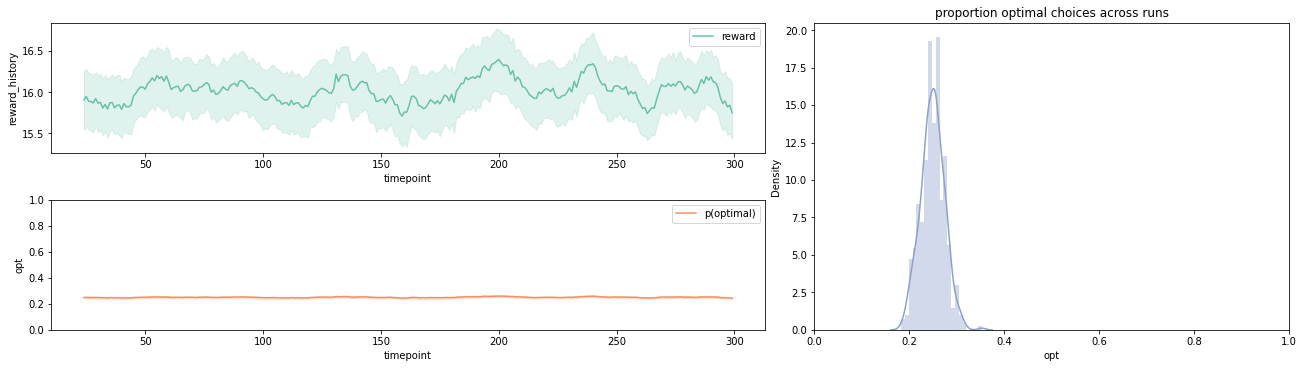

In [53]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
bandit_means = [0,50,10,4]
bandit_sds = [1]*n_bandits

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = RandomAgent(n_bandits)
    np.random.shuffle(bandit_means) # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means,bandit_sds) # create a new bandit
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

Here the plot shows the average reward earned for each trial fo the task across the repeated runs/experiments.  The lower panel shows the proportion of optimal choices made by the agent across trials.  The error bars on both of these plots are bootstrapped confidence intervals across runs of the agent.  Finally, the right panel shows a histogram of the proportion of optimal choices made across the runs.

Everything looks as expected here.  The random agent makes about the average reward of the task and chooses the optimal choice about 25% of the time.

Can you use what we have learned in lecture to do better?

<div class="alert alert-success" role="alert">
<h3> Problem 4 (15 points) </h3><br>
  Create a new agent class based on `RandomAgent` called `EpsilonGreedyAgentIncremental()` which keeps track of the average reward earned from each draw of the bandit.  This agent will include a parameter `epsilon` which will determine the probability of choosing a random action, otherwise it should choose the best so far.  To update the value of each bandit use the incremental implementation of mean-tracking which was first introduced on the slides blending monte carlo methods (this is a incremental approach to calculating the mean as a new observation arrive).  Make a plot similar to the ones above showing the performance of the agent on the three measures we have considered when the environment is initialized in the same way (i.e., means are a random shuffling of [0.,50.,10.,4.] with sd=1).  Next, show with a couple examples how changes in epsilon determine the shape of that plot.  You should show the final code for your agent and the plots along with a single markdown cell describing your solution (1-2 paragraphs).  In your answer be sure to explain if your new agent does better than the random agent and why you think that is the case.  In all cases run your agent for 300 time steps and average over 500 runs.
</div>

- Change in Epsilon shifts the proportion of optimal choice distribution graph left as Epsilon value gets closer to 1. Opposingly, as Epsilon gets closer to 0, proportion of optimal choice distribution graph to right. This means when Epsilon is closer to 0, the proportion that the algorithm makes the optimal choice is higher. This trend is shown with below plots for epsilon = 0.1, 0.5, 0.9.

- Below is the code for EpsilonGreedyAgentIncremental where I initialize variables k num_actions, epsilon, Q table for value of each action, and N table for counting the number of visits to each action. Then, choose function incorporates epsilon greedy algorithm where less than epsilon random probability chooses the action randomly and greater than epsilon chooses the action with maximum Q value. Finally, learn function takes in reward and action as a parameter; then, N table is incremented by 1 everytime an action is performed (i.e. pulling the nth arm). New EpsilonGreedyAgentIncremental() agent does better than the random agent because it incorporates epsilon greedy algorithm as well as exploring random action when choosing the action of the agent. Also, learn function allows the agent to learn from the action choice using the Q(a) table that updates the value of an action with formula Q(a) = Q(a) + 1/N(a) * (reward - Q(a)). On the other hand, RandomAgent() randomly chooses the action and does not learn from the action. As a result, random agent does not improve proportion of optimal choices even after many iterations. 

In [54]:
class EpsilonGreedyAgentIncremental():
    def __init__(self, k, epsilon):
        self.num_actions = k
        self.epsilon = epsilon # determines the prob of choosing a random action/ otherwise choose best one so far.
        # you could add parameters to your agent here
        
        # list of 0's with k elements; value table for each action/ nth arm
        self.Q = list(0 for i in range(0, k))
        # list of 0's with k elements; # of times nth arms are pulled/chosen
        self.N = list(0 for i in range(0, k))
    
    def choose(self): # this method returns integer that represent the arm in N-bandit
        probability = random.random()
        if probability < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            # return the argmax action from Q
            max_index = np.argmax(self.Q)
            return max_index
    
    def learn(self, reward, action):
        # increment nth arm index's value every time it is chosen/visited
        self.N[action] += 1
        # update Q-table (aka V(s) value table for each action/nth arm pulled)
        self.Q[action] += (1/self.N[action]) * (reward - self.Q[action])

### With epsilon = 0.1

/Users/changhyunlee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


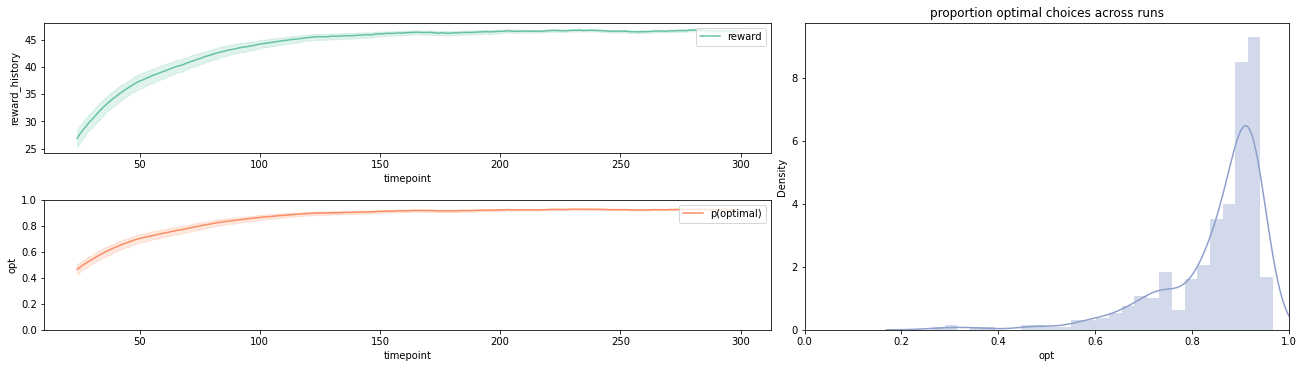

In [55]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
bandit_means = [0,50,10,4]
bandit_sds = [1]*n_bandits
epsilon = 0.1

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentIncremental(n_bandits,epsilon)
    np.random.shuffle(bandit_means) # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means,bandit_sds) # create a new bandit
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

### With epsilon = 0.5

/Users/changhyunlee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


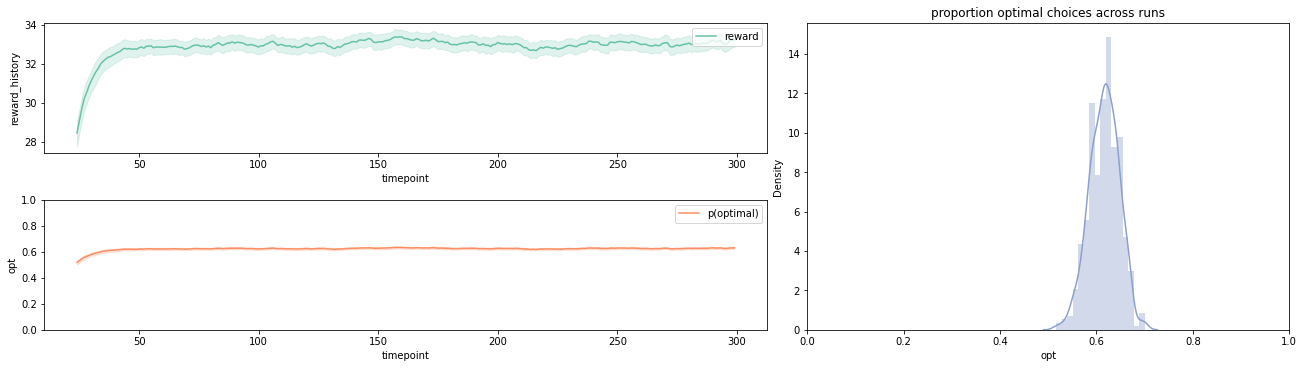

In [56]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
bandit_means = [0,50,10,4]
bandit_sds = [1]*n_bandits
epsilon = 0.5

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentIncremental(n_bandits,epsilon)
    np.random.shuffle(bandit_means) # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means,bandit_sds) # create a new bandit
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

### With epsilon = 0.9

/Users/changhyunlee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


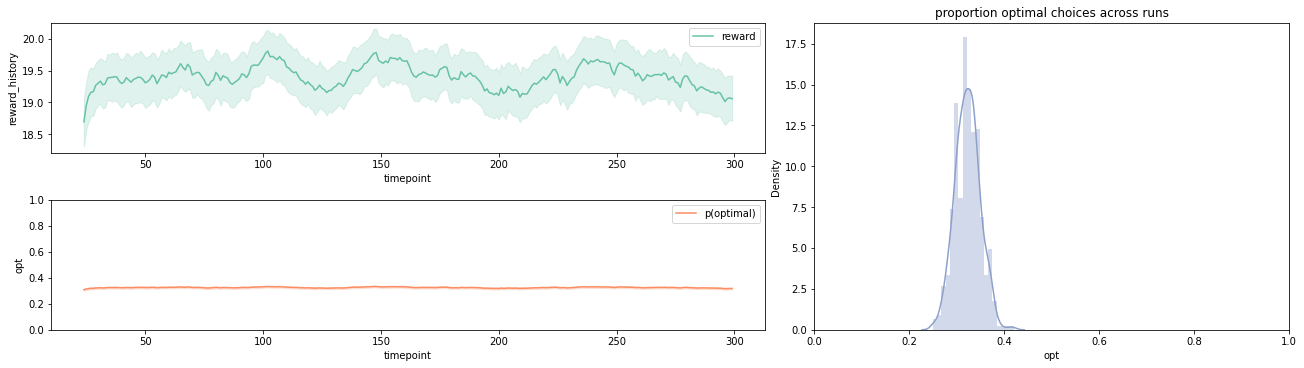

In [57]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
bandit_means = [0,50,10,4]
bandit_sds = [1]*n_bandits
epsilon = 0.9

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentIncremental(n_bandits,epsilon)
    np.random.shuffle(bandit_means) # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means,bandit_sds) # create a new bandit
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

<div class="alert alert-success" role="alert">
<h3> Problem 5 (15 points) </h3><br> 
Create a new agent class based on `RandomAgent` called `EpsilonGreedyAgentConstant()` which keeps track of the average reward earned from each draw of the bandit.  This agent will be nearly identical to `EpsilonGreedyIncremental()`.  However, in addition to the parameter `epsilon` which will determine the probability of choosing a random action, this agent should use the "constant step size" update rule related to temporal-different learning to update the value of each action.  The step size parameter (`alpha`) should be added as a new input parameter to your agent (hint: small values of this parameter are often better).   Make a plot similar to the ones above showing the performance of the agent on the three measures we have considered.  Is the performance of this agent the same or different than the previous agent you coded for this environment?  Try a few parameter combinations with your agent and in your response show 1-2 examples to help make your point.  You should show the final code for your agent and the plots along with a single markdown cell describing your solution (1-2 paragraphs). Be sure that your answer includes the answer to this key question: Does the constant agent out perform the incremental agent?  And does it do better than the random agent?  You don't need to do statistics but just a general visual comparison of the quality of the algorithsm is enough.  In all cases run your agent for 300 time steps and average over 500 runs.
</div>

- The performance of this agent is a little different than the previous agent you coded for this environment because setting same epsilon value = 0.1 and alpha value = 0.7, 0.5 and plotting the graphs, I got similar proportion of optimal choices near 90% which is very close to the EpsilonGreedyAgentIncremental(). However, there was a very slightly more left skewedness with alpha = 0.7. Nontheless, previous incremental agent with epsilon = 0.1 also has very high proportion of optimal choices if not better than constant agent, so it is hard to define exactly whether constant agent is better than incremental agent.
- My Constant agent solution has constructor with parameters num actions k, epsilon, alpha, Q table for each action values, and N table for counting number of visits to action. Choose function follows the exact same epsilon greedy algorithm as the incremental agent. Finally, the Q table update algorithm uses alpha in place of 1/N(a) from incremental agent.
- The constant agent does not necessarily outperform the incremental agent because they are different methods of updating Q table. It may be more adapatable to environments that favors equal impact/update of action values across all nth actions. Unlike constant agent, incremental agent decreases the impact of actions with large # of visits from the 1/N(a) term. Nonetheless, constant agent is definitely better than random agent which does not converge to policy solution due to agent not learning from its actions.

In [77]:
class EpsilonGreedyAgentConstant():
    def __init__(self, k, epsilon, alpha):
        self.num_actions = k
        self.epsilon = epsilon # determines the prob of choosing a random action/ otherwise choose best one so far.
        self.alpha = alpha
        # you could add parameters to your agent here
        
        # list of 0's with k elements; value table for each action/ nth arm
        self.Q = list(0 for i in range(0, k))
        # list of 0's with k elements; # of times nth arms are pulled/chosen
        self.N = list(0 for i in range(0, k))
    
    def choose(self): # this method returns integer that represent the arm in N-bandit
        probability = random.random()
        if probability < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            # return the argmax action from Q
            max_index = np.argmax(self.Q)
            return max_index
    
    def learn(self, reward, action): # this agent doesn't learn
        self.N[action] += 1
        self.Q[action] += self.alpha * (reward - self.Q[action])

## epsilon = 0.1, alpha = 0.7

/Users/changhyunlee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


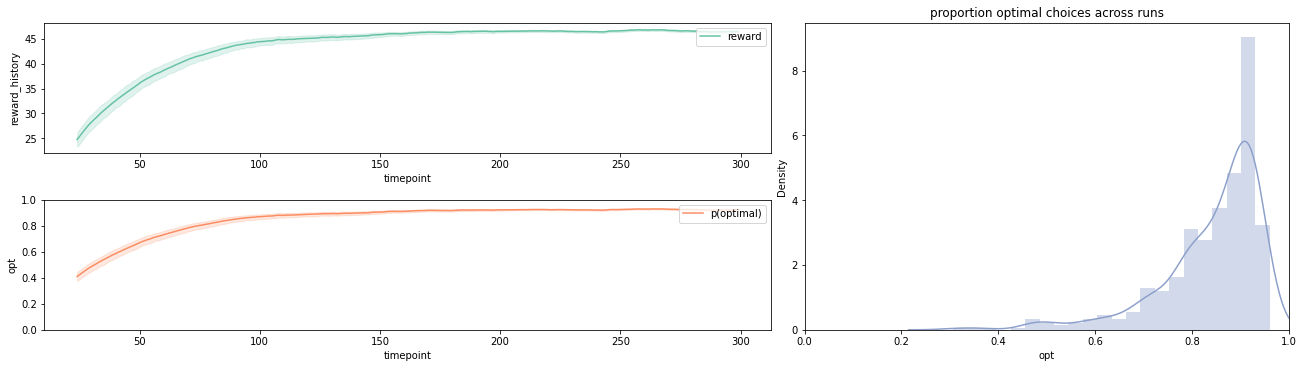

In [81]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
bandit_means = [0,50,10,4]
bandit_sds = [1]*n_bandits
epsilon = 0.1
alpha = 0.7 # step-size

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits,epsilon, alpha)
    np.random.shuffle(bandit_means) # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means,bandit_sds) # create a new bandit
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

## epsilon = 0.1, alpha = 0.5

/Users/changhyunlee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


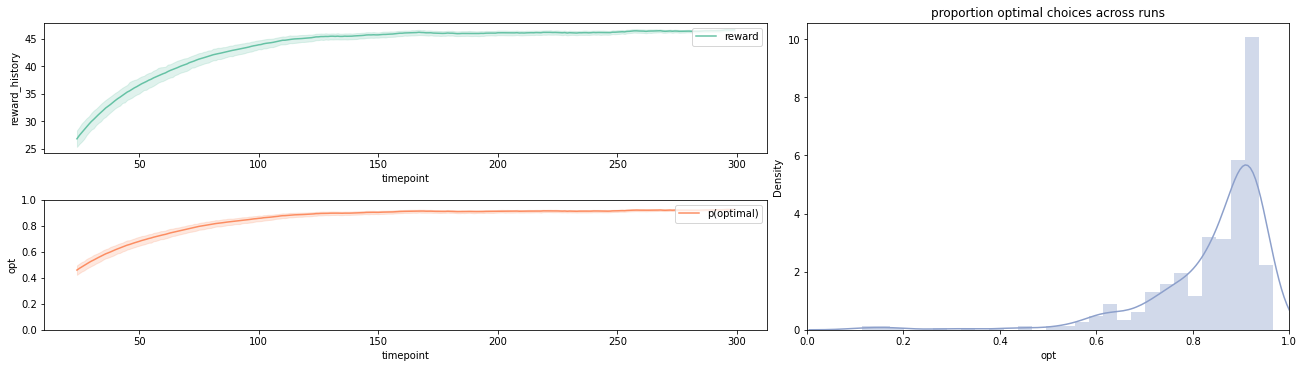

In [82]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
bandit_means = [0,50,10,4]
bandit_sds = [1]*n_bandits
epsilon = 0.1
alpha = 0.5 # step-size

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits,epsilon, alpha)
    np.random.shuffle(bandit_means) # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means,bandit_sds) # create a new bandit
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

<div class="alert alert-success" role="alert">
<h3> Problem 6 (15 points) </h3><br> 
      Below is a new type of bandit environment based on `KArmBanditStationary` class where the reward probabilities of each bandit change over time.  This is sometimes known as a "restless bandit" (see the Daw et al. 2013 paper on explore exploit mentioned in Lecture).  The idea is that on each time step the mean reward of each action should be modified up or down by a sample from a Gaussian distribution (e.g.,  $\mu_{t+1} = \mu_{t} + \mathcal{N}(0,20)$).  I have called the new class `KArmBanditRestless`.  The mean of the arms is itself drawn intiailly from a random normal distribution as well. Using this environment (with the number of arms set to 4), test the `RandomAgent()`, `EpsilonGreedyAgentConstant()` and `EpsilonGreedyAgentIncremental()` agents.  You may want to play with the alpha parameter of the incremental agent to see if you can find a particularly good setting.  Show the final code for your agent, plots showing the average reward the agent earns over time, along with a  markdown cell describing your solution in 1-2 paragraphs.  Which agent performs better in this environment?  Is this different than the conclusion you made from the previous environment? Be sure to answer these two questions in your response.  In all cases run your agent for 300 time steps and average over 500 runs.
</div>

- My solution includes 3 different agents (Random, Constant, and Incremental) with KArmBanditRestless as a bandit. For each of them, I set up parameters of simulation including time_steps and number of runs. Also, I set up bandit options, such as # of bandits, bandit means, and bandit standard deviations and any necessary parameters. In the for loop, I created the agent and bandit, and each run, agent chose an action and learned from the action to update the Q table for better rate of choosing optimal action.
- Average reward the agent earns over time is plotted for each agent methods
- In this environment, contant agent with epsilon = 0.1 and alpha = 0.5 performed the best based on the proportion of optimal choices distribution plot. This agent has the most left skewed plot of optimal choices graph, meaning it had the highest rate of choosing the optimal choice out of the three agents. Also, the width of the distribution was narrower than incremental agent, meaning less variance in the proportion.
- This is different than the conclusion of previous environment because in the previous stationary bandit, incremental agent (with epsilon = 0.1) in general had a very high performance almost better than that of constant agent. At the least, in the stationary bandit environment, incremental agent and constant agent had similar proportion of choosing optimal action with same exact parameters as in the restless bandit case. Instead, restless bandit environment makes it obvious that constant agent performs better than incremental agent because of the dynamic environment. Mean reward of each action is modified from Gaussian distribution impacting the update of Q(a) values, and this kind of dynamic environment works better with constant step-size alpha, where each discrepancy term (R-Q(a)) will have same influence.

In [101]:
class KArmBanditRestless():
    def __init__(self, k, mu=0, sigma=2, sd=2, walk_sd=30):
        self.k = k
        self.action_means = np.random.normal(mu, sigma, k)
        self.action_sds = sd
        self.walk_sd = walk_sd
        self.optimal = np.argmax(self.action_means)
        
    def step(self, action):
        out = np.random.normal(self.action_means[action], self.action_sds), action==self.optimal
        self.action_means = self.action_means + np.random.normal(0.0, self.walk_sd, self.k)
        self.optimal = np.argmax(self.action_means)
        return out

In [102]:
# intialize this bandit like this
n_bandits = 4
bandit = KArmBanditRestless(n_bandits)

## RandomAgent()

/Users/changhyunlee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


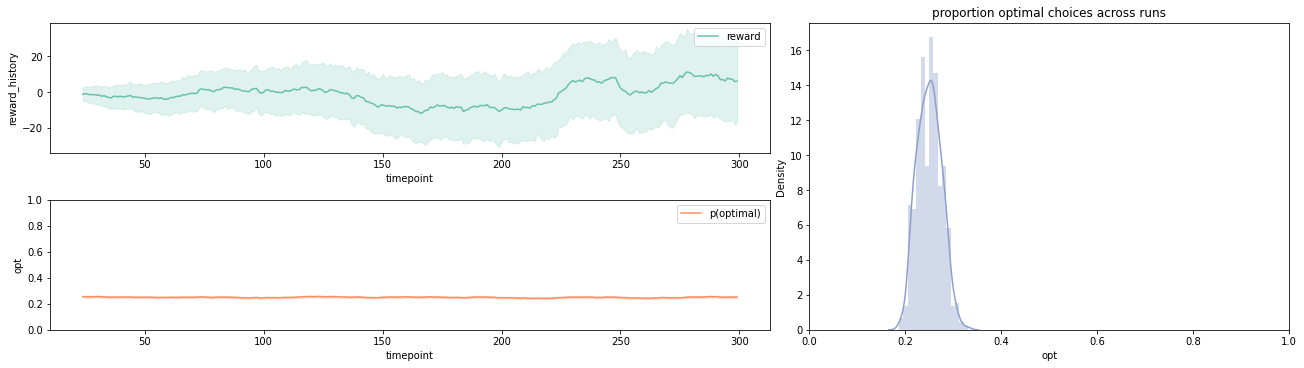

In [122]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
bandit_means = [0,50,10,4]
bandit_sds = [1]*n_bandits

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = RandomAgent(n_bandits)
    bandit = KArmBanditRestless(n_bandits) # create new bandit
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

Text(0.5, 1.0, 'average rewards plot over runs')

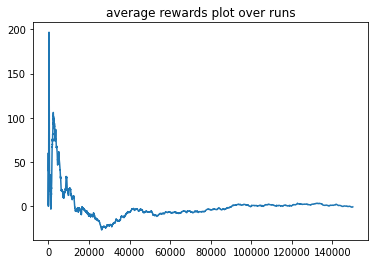

In [123]:
# plotting average rewards plot over time
avg_reward_list = []
sum_reward = 0
for i in range(len(reward_history)):
    sum_reward += reward_history[i]
    avg_reward_list.append(sum_reward/(i+1))
plt.plot(avg_reward_list)
plt.title("average rewards plot over runs")

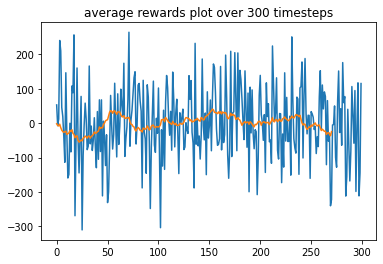

In [124]:
# plotting average rewards plot over time
avg_reward_list = []
sum_reward = 0
for i in range(len(reward_history)):
    sum_reward += reward_history[i]
    if (i+1) % n_runs == 0:
        avg_reward_list.append(sum_reward/n_runs)
        sum_reward = 0
def running_mean(x, N):
    #x == an array of data. N == number of samples per average
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
moving_avg = running_mean(avg_reward_list, 30)
plt.plot(avg_reward_list)
plt.plot(moving_avg)
plt.title("average rewards plot over 300 timesteps")
plt.show()

## EpsilonGreedyAgentIncremental()

/Users/changhyunlee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


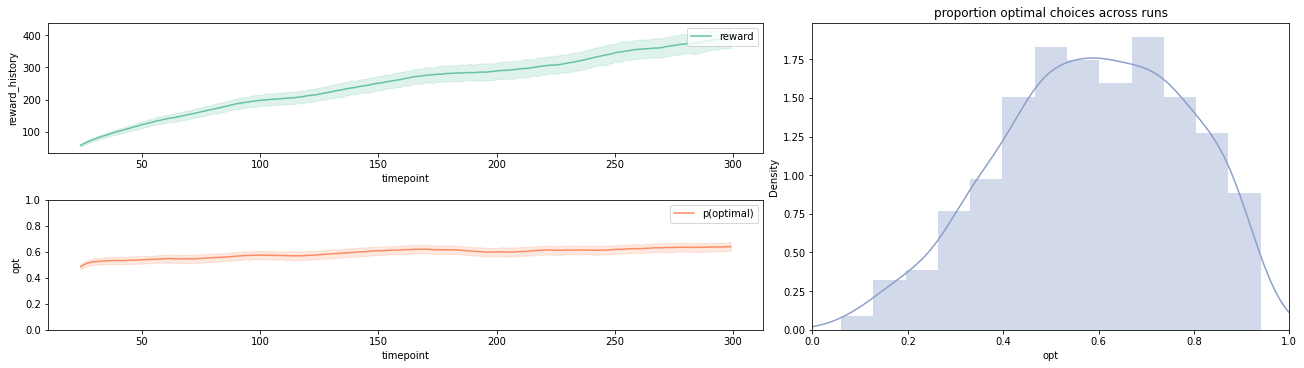

In [125]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
epsilon = 0.1

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentIncremental(n_bandits, epsilon)
    bandit = KArmBanditRestless(n_bandits)# create a new bandit
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

Text(0.5, 1.0, 'average rewards plot over runs')

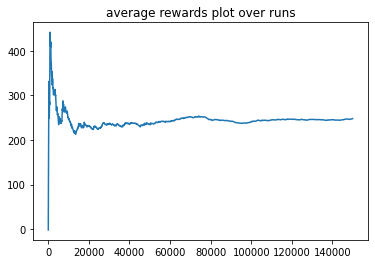

In [126]:
# plotting average rewards plot over time
avg_reward_list = []
sum_reward = 0
for i in range(len(reward_history)):
    sum_reward += reward_history[i]
    avg_reward_list.append(sum_reward/(i+1))
plt.plot(avg_reward_list)
plt.title("average rewards plot over runs")

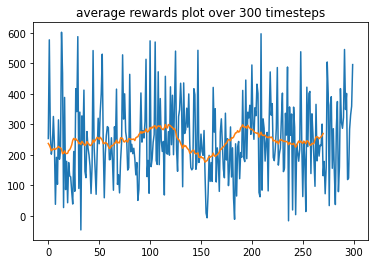

In [127]:
# plotting average rewards plot over time
avg_reward_list = []
sum_reward = 0
for i in range(len(reward_history)):
    sum_reward += reward_history[i]
    if (i+1) % n_runs == 0:
        avg_reward_list.append(sum_reward/n_runs)
        sum_reward = 0
def running_mean(x, N):
    #x == an array of data. N == number of samples per average
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
moving_avg = running_mean(avg_reward_list, 30)
plt.plot(avg_reward_list)
plt.plot(moving_avg)
plt.title("average rewards plot over 300 timesteps")
plt.show()

## EpsilonGreedyAgentConstant() with epsilon = 0.08, alpha = 0.5

/Users/changhyunlee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


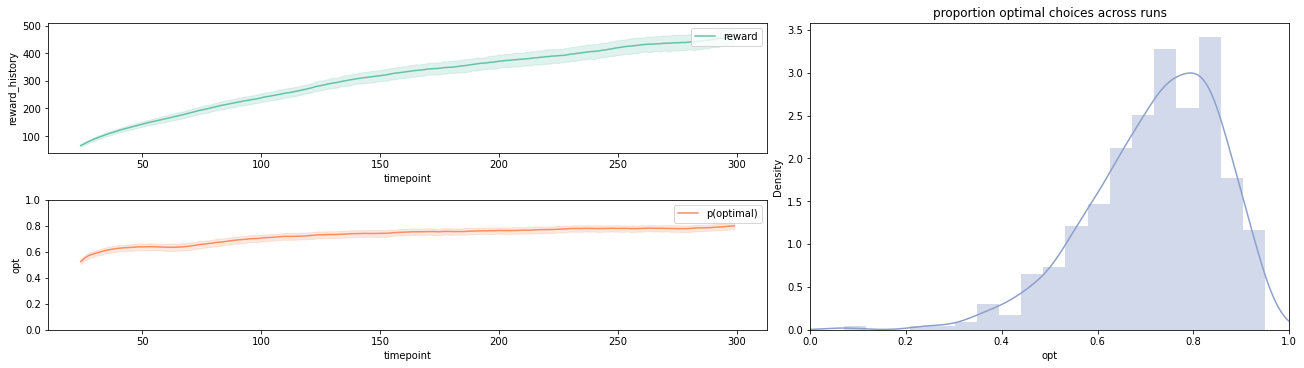

In [128]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
epsilon = 0.08
alpha = 0.5

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon, alpha)
    bandit = KArmBanditRestless(n_bandits) # create new bandit
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

Text(0.5, 1.0, 'average rewards plot over runs')

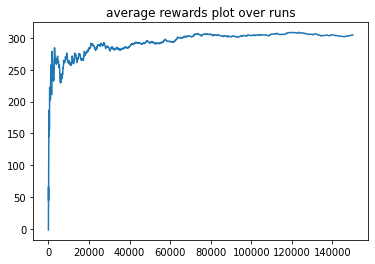

In [129]:
# plotting average rewards plot over time
avg_reward_list = []
sum_reward = 0
for i in range(len(reward_history)):
    sum_reward += reward_history[i]
    avg_reward_list.append(sum_reward/(i+1))
plt.plot(avg_reward_list)
plt.title("average rewards plot over runs")

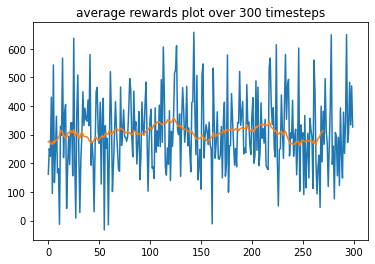

In [130]:
# plotting average rewards plot over time
avg_reward_list = []
sum_reward = 0
for i in range(len(reward_history)):
    sum_reward += reward_history[i]
    if (i+1) % n_runs == 0:
        avg_reward_list.append(sum_reward/n_runs)
        sum_reward = 0
def running_mean(x, N):
    #x == an array of data. N == number of samples per average
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
moving_avg = running_mean(avg_reward_list, 30)
plt.plot(avg_reward_list)
plt.plot(moving_avg)
plt.title("average rewards plot over 300 timesteps")
plt.show()

## EpsilonGreedyAgentConstant() with epsilon = 0.1, alpha = 0.5

/Users/changhyunlee/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


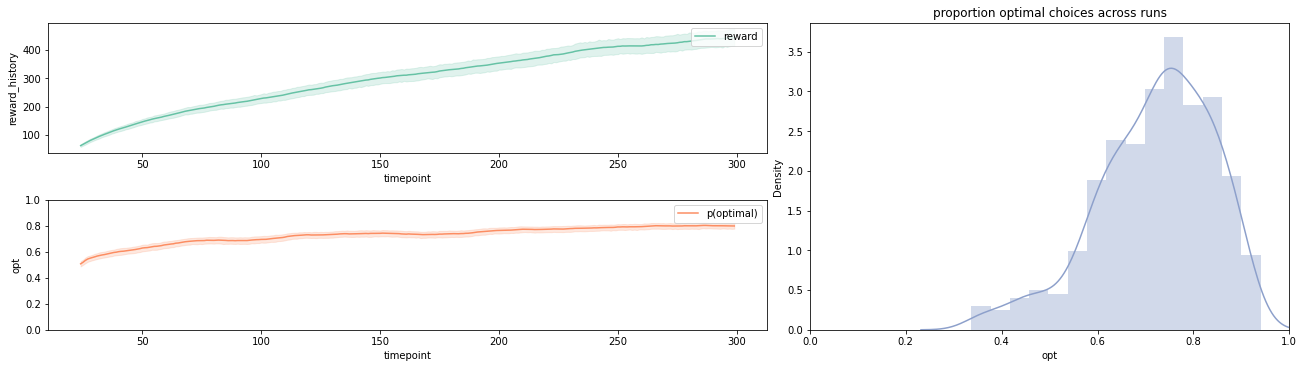

In [140]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
epsilon = 0.1
alpha = 0.5

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    agent = EpsilonGreedyAgentConstant(n_bandits, epsilon, alpha)
    bandit = KArmBanditRestless(n_bandits) # create new bandit
    for i in range(n_timesteps): # for a certain number of time steps
        choice = agent.choose() # let the agent choose
        reward, opt = bandit.step(choice)
        agent.learn(reward, choice)
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)

# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

Text(0.5, 1.0, 'average rewards plot over timesteps')

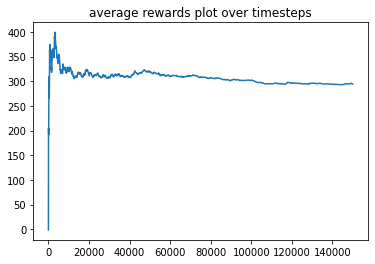

In [141]:
# plotting average rewards plot over time
avg_reward_list = []
sum_reward = 0
for i in range(len(reward_history)):
    sum_reward += reward_history[i]
    avg_reward_list.append(sum_reward/(i+1))
plt.plot(avg_reward_list)
plt.title("average rewards plot over timesteps")

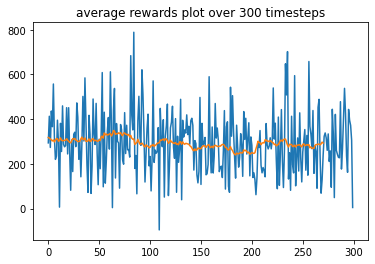

In [142]:
# plotting average rewards plot over time
avg_reward_list = []
sum_reward = 0
for i in range(len(reward_history)):
    sum_reward += reward_history[i]
    if (i+1) % n_runs == 0:
        avg_reward_list.append(sum_reward/n_runs)
        sum_reward = 0
def running_mean(x, N):
    #x == an array of data. N == number of samples per average
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
moving_avg = running_mean(avg_reward_list, 30)
plt.plot(avg_reward_list)
plt.plot(moving_avg)
plt.title("average rewards plot over 300 timesteps")
plt.show()

<div class="alert alert-success" role="alert">
<h3> Problem 7 (15 points) </h3><br>
 
For this problem, we return to the grid world task we considered in Part A.  Specifically, you should combine the ideas about explore-exploit and incremental learning of q-values to implement a temporal-difference solution the to grid world problem you explored in Part A of the homework.  You can reuse the code from that notebook in building your solution.  This solution should also obtain similar results to the policy-iteration and monte-carlo versions you explored, but is learned more incrementally and online.  

The basic setup of the GridWorld environment is provided again for you below.  Your solution to this problem should involve modifications to the solution to the Monte-Carlo problems in Part A.  In particular, instead of waiting until a particular episode ends to update the values of the Q-values, use the Q-learning equation to incrementally updates these values as an episode unfolds.  To balance exploration and exploitation try any of the methods you developed in the earlier parts of this assignment.

As a reminder the question for updating the Q values in Q-learning is as follows:

$Q(s,a) = Q(s,a) + \alpha [r +\gamma  max_{a'} Q(s',a') - Q(s,a)] $

The pseudo code for this algorithm is:
```
Initialize, for all $s \in S$, $a \in A(s)$:
    $Q(s,a)$ <- arbitrary

Repeat many times (for each episode):
    a) Initialize $s$ at the start state
    b) Repeat
        1. Choose action $a$ from $s$ using policy dervived from Q values in that state (e.g., SoftMax)
        2. Take action $a$, observe $r$, $s'$
        3. Update $Q(s,a)$
           Find max Q(s',a') over all action a' in state s'
           $Q(s,a) = Q(s,a) + \alpha [r + \gamma max Q(s',a') - Q(s,a)]$
           $s$ <- $s'$
       Until $s$ is the goal state
```


</div>

In [65]:
# import the gridworld library
import numpy as np
import random
import math
import statistics
from copy import deepcopy
from IPython.display import display, Markdown, Latex, HTML
from gridworld import GridWorld, random_policy

In [66]:
gridworld = [
       [ 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'x', 'g'],
       [ 'o', 'x', 'x', 'o', 'x', 'x', 'o', 'x', 'o'],
       [ 'o', 'x', 'x', 'o', 'x', 'x', 'o', 'x', 'o'],
       [ 'o', 'x', 'x', 'o', 'x', 'x', 'o', 'o', 'o'],
       [ 'o', 'x', 'x', 'o', 'x', 'x', 'x', 'o', 'o'],
       [ 's', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'x']
    ] # the problem described above, 'x' is a wall, 's' is start, 'g' is goal, and 'o' is a normal room


mygrid = GridWorld(gridworld)
mygrid.raw_print()  # print out the grid world
mygrid.index_print() # print out the indicies of each state
mygrid.coord_print() # print out the coordinates of each state (helpful in your code)

# define the rewards as a hash table
rewards={}

# mygrid.transitions contains all the pairwise state-state transitions allowed in the grid
# for each state transition intialize the reward to zero
for start_state in mygrid.transitions:
    for action in mygrid.transitions[start_state].keys():
        next_state = mygrid.transitions[start_state][action]
        rewards[str([start_state, action, next_state])] = 0.0

# now set the reward for moving up into state 8 (the goal state) to +10
rewards[str([17, 'up', 8])] = 10

# now set the penalty for walking off the edge of the grid and returning to state 45 (the start state)
for i in [0,1,2,3,4,5,6,7]:
    rewards[str([i, 'up', 45])] = -1
for i in [0,9,18,27,36,45]:
    rewards[str([i, 'left', 45])] = -1
for i in [45,46,47,48,49,50,51,52,53]:
    rewards[str([i, 'down', 45])] = -1
for i in [8,17,26,35,44,53]:
    rewards[str([i, 'right', 45])] = -1

## Welcome to your new Grid World!

**Raw World Layout**

o,o,o,o,o,o,o,x,g
o,x,x,o,x,x,o,x,o
o,x,x,o,x,x,o,x,o
o,x,x,o,x,x,o,o,o
o,x,x,o,x,x,x,o,o
s,o,o,o,o,o,o,o,x


**Indexes of each grid location as an id number**

0,1,2,3,4,5,6,7,8
9,10,11,12,13,14,15,16,17
18,19,20,21,22,23,24,25,26
27,28,29,30,31,32,33,34,35
36,37,38,39,40,41,42,43,44
45,46,47,48,49,50,51,52,53


**Indexes of each grid location as a tuple**

"(0,0)","(0,1)","(0,2)","(0,3)","(0,4)","(0,5)","(0,6)","(0,7)","(0,8)"
"(1,0)","(1,1)","(1,2)","(1,3)","(1,4)","(1,5)","(1,6)","(1,7)","(1,8)"
"(2,0)","(2,1)","(2,2)","(2,3)","(2,4)","(2,5)","(2,6)","(2,7)","(2,8)"
"(3,0)","(3,1)","(3,2)","(3,3)","(3,4)","(3,5)","(3,6)","(3,7)","(3,8)"
"(4,0)","(4,1)","(4,2)","(4,3)","(4,4)","(4,5)","(4,6)","(4,7)","(4,8)"
"(5,0)","(5,1)","(5,2)","(5,3)","(5,4)","(5,5)","(5,6)","(5,7)","(5,8)"


<div class="alert alert-info" role="alert">
  
  The following code sets up the major things you need to track.  Note that unlike in the Monte Carlo solution you do not need a separate accounting of the returns as you are updating those to the Q-values directly.
  
  Also you shouldn't need to update the policy table until you have run many episodes through the maze.  The final update to the `policy_table` should just to be to print out your final greedy solution and compare it to the solutions you obtained in Part A.
 
</div>

In [71]:
starting_state = 45
goal_state = 8 # terminate the MC roll out when you get to this state
GAMMA=0.9
EPSILON = 0.2
ALPHA = 0.5


# set up initial data strucutres that might be useful for you
# q(s,a) - the q-values for each action in each state
def zero_q_values():
    qvals = {"up": 0.0, "right": 0.0, "down": 0.0, "left": 0.0}
    return qvals
q_value_table = [[zero_q_values() for i in range(mygrid.ncols)] for j in range(mygrid.nrows)]

# pi - the policy table
policy_table = [[random_policy() for i in range(mygrid.ncols)] for j in range(mygrid.nrows)]
display(Markdown("**Initial (randomized) policy**"))
mygrid.pretty_print_policy_table(policy_table)

**Initial (randomized) policy**

↓,↓,↓,↓,→,↑,↑,▉,↓
↓,▉,▉,←,▉,▉,←,▉,→
↓,▉,▉,←,▉,▉,↑,▉,↑
←,▉,▉,↓,▉,▉,→,→,→
←,▉,▉,→,▉,▉,▉,↑,↑
↑,←,→,→,→,↓,→,→,▉


In [72]:
def be_greedy(q_values):
    if len(q_values)==0:
        return {}
    
    keys = list(q_values.keys())
    vals = [q_values[i] for i in keys]    
    maxqs = [i for i,x in enumerate(vals) if x==max(vals)]
    if len(maxqs)>1:
        pos = random.choice(maxqs)
    else:
        pos = maxqs[0]
    policy = deepcopy(q_values)
    for i in policy.keys():
        policy[i]=0.0
    policy[keys[pos]]=1.0
    return policy

## 50000 Iterations

In [73]:
ITERATIONS=50000

from tqdm import tqdm
for i in tqdm(range(ITERATIONS)):  # you probably need to take many, many steps here and it make take some time to run
    # instead of always starting at the start state, this algorithm will use the concept of an 
    # "exploring start" so that it starts in a random valid state
    # this can help a lot
    curr_state = starting_state  # select and exploring start state

    
    while curr_state != goal_state:
        # initialize all global variables
        best_action = ''
        best_value = -999999999
        sx, sy = mygrid.index_to_coord(curr_state)
        next_state = 0
        
        # choose a based on Q(s,a) with epsilon-greedy algorithm
        if random.random() < EPSILON:
            # choosing random action a
            best_action = random.choice(['right', 'left', 'up', 'down'])
        else:
            
            for a in ['right', 'left', 'up', 'down']:
                if q_value_table[sx][sy][a] > best_value:
                    best_value = q_value_table[sx][sy][a]
                    best_action = a
        
        # finding next_state (integer)
        next_state = mygrid.transitions[curr_state][best_action]
        
        # calculate reward for curr_state
        reward = rewards[str([curr_state, best_action, next_state])]
        
        # calculate max_a_Q_s'_a'
        best_action2 = ''
        best_value2 = -99999999
        
        # next_state coordinates
        sx2, sy2 = mygrid.index_to_coord(next_state)
        
        # finding best_action2 for next state
        for a in ['right', 'left', 'up', 'down']:
            if q_value_table[sx2][sy2][a] > best_value2:
                best_value2 = q_value_table[sx][sy][a]
                best_action2 = action
        max_a_Q_s_prime_a_prime = q_value_table[sx2][sy2][best_action2]
        
        # **** update q value table *****
        q_value_table[sx][sy][best_action] += ALPHA * (reward + GAMMA * max_a_Q_s_prime_a_prime - q_value_table[sx][sy][best_action])
    
        # update the current state to next state
        curr_state = next_state
        
# improve policy
for sx in range(len(q_value_table)):
    for sy in range(len(q_value_table[sx])):
        policy_table[sx][sy] = be_greedy(q_value_table[sx][sy])

# if i%PRINT_EVERY==0:
#     display(Markdown(f"**Improved policy interation {i}**"))
#     mygrid.pretty_print_policy_table(policy_table)
        
display(Markdown("**Improved policy**"))
mygrid.pretty_print_policy_table(policy_table)

100%|██████████| 50000/50000 [30:49<00:00, 27.04it/s] 


**Improved policy**

→,→,→,↓,→,→,↓,▉,↓
→,▉,▉,←,▉,▉,→,▉,↑
↑,▉,▉,↓,▉,▉,→,▉,↓
→,▉,▉,↓,▉,▉,↓,←,↑
↑,▉,▉,←,▉,▉,▉,←,↓
→,→,→,↑,→,→,→,↑,▉


## 200000 iterations

In [74]:
starting_state = 45
goal_state = 8 # terminate the MC roll out when you get to this state
GAMMA=0.9
EPSILON = 0.2
ALPHA = 0.5


# set up initial data strucutres that might be useful for you
# q(s,a) - the q-values for each action in each state
def zero_q_values():
    qvals = {"up": 0.0, "right": 0.0, "down": 0.0, "left": 0.0}
    return qvals
q_value_table = [[zero_q_values() for i in range(mygrid.ncols)] for j in range(mygrid.nrows)]

# pi - the policy table
policy_table = [[random_policy() for i in range(mygrid.ncols)] for j in range(mygrid.nrows)]
display(Markdown("**Initial (randomized) policy**"))
mygrid.pretty_print_policy_table(policy_table)

**Initial (randomized) policy**

↑,↓,←,→,→,↓,↓,▉,←
↑,▉,▉,↑,▉,▉,↓,▉,←
↓,▉,▉,↓,▉,▉,←,▉,→
←,▉,▉,↓,▉,▉,↑,↑,↑
←,▉,▉,↓,▉,▉,▉,←,↓
↑,→,↓,↓,↑,↑,←,←,▉


In [76]:
ITERATIONS=200000

from tqdm import tqdm
for i in tqdm(range(ITERATIONS)):  # you probably need to take many, many steps here and it make take some time to run
    # instead of always starting at the start state, this algorithm will use the concept of an 
    # "exploring start" so that it starts in a random valid state
    # this can help a lot
    curr_state = starting_state  # select and exploring start state

    
    while curr_state != goal_state:
        # initialize all global variables
        best_action = ''
        best_value = -99999999
        sx, sy = mygrid.index_to_coord(curr_state)
        next_state = 0
        
        # choose a based on Q(s,a) with epsilon-greedy algorithm
        if random.random() < EPSILON:
            # choosing random action a
            best_action = random.choice(['right', 'left', 'up', 'down'])
        else:
            
#             for a in ['right', 'left', 'up', 'down']:
#                 if q_value_table[sx][sy][a] > best_value:
#                     best_value = q_value_table[sx][sy][a]
#                     best_action = a
            best_action = max(q_value_table[sx][sy], key = q_value_table[sx][sy].get)        
        next_state = mygrid.transitions[curr_state][best_action]
        
        # calculate reward for curr_state
        reward = rewards[str([curr_state, best_action, next_state])]
        
        # calculate max_a_Q_s'_a' for next state
        best_action2 = ''
        best_value2 = -99999999
        sx2, sy2 = mygrid.index_to_coord(next_state)
        # for a in ['right', 'left', 'up', 'down']:
        #     if q_value_table[sx2][sy2][a] > best_value2:
        #         best_value2 = q_value_table[sx][sy][a]
        #         best_action2 = action
        best_action2 = max(q_value_table[sx2][sy2], key = q_value_table[sx2][sy2].get)
        max_a_Q_s_prime_a_prime = q_value_table[sx2][sy2][best_action2]
        
        # **** update q value table *****
        q_value_table[sx][sy][best_action] += ALPHA * (reward + GAMMA * max_a_Q_s_prime_a_prime - q_value_table[sx][sy][best_action])
    
        # update the current state to next state
        curr_state = next_state
        
# improve policy
for sx in range(len(q_value_table)):
    for sy in range(len(q_value_table[sx])):
        policy_table[sx][sy] = be_greedy(q_value_table[sx][sy])

# if i%PRINT_EVERY==0:
#     display(Markdown(f"**Improved policy interation {i}**"))
#     mygrid.pretty_print_policy_table(policy_table)
        
display(Markdown("**Improved policy**"))
mygrid.pretty_print_policy_table(policy_table)

100%|██████████| 200000/200000 [00:21<00:00, 9320.92it/s] 


**Improved policy**

→,→,→,→,→,→,↓,▉,↑
↑,▉,▉,↑,▉,▉,↓,▉,↑
↑,▉,▉,↑,▉,▉,↓,▉,↑
↓,▉,▉,↓,▉,▉,→,→,↑
↓,▉,▉,↓,▉,▉,▉,→,↑
→,→,→,→,→,→,→,↑,▉


Compared to Part A, the improved policy table looks very similar with temporal method at 200K iterations. We can see the policy table converged to a similar solution.